In [6]:
import numpy as np
from keras.utils.vis_utils import plot_model
import random
import tensorflow as tf
import graphviz
import pydot
from tensorflow import keras
from tensorflow.keras import layers
from cartpole_environment import CartPoleEnv #'cartpole_environment' is how I named the gym file, possibly needs to be changed

pygame 2.1.2 (SDL 2.0.18, Python 3.8.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [14]:
###SETUP###
gamma = 0.995
num_actions = 2
state_shape = 4
policy = 'egreedy'
experience_replay = True
decay_epsilon = True #This is to perform dynamic epsilon-greedy exploration by decaying the value of epsilon 
#with time

epsilon = 1  # Epsilon greedy parameter
epsilon_min = 0.01
decay_rate = 0.95
batch_size = 20  # Size of batch taken from replay buffer

game = CartPoleEnv()

In [10]:
###BUILD THE ARCHITECTURE OF THE MODEL###
def build_architecture(learning_rate = 0.001):
    inputs = keras.Input(shape=(4,))
    x = layers.Dense(24, activation = 'relu')(inputs)   #Tried with 100 nodes also, but apparently there's no improvement
    x = layers.Dense(24, activation = 'relu')(x)
    #x = layers.Dense(24, activation = 'relu')(x) #Let's see what happens when removing a layer
    outputs = layers.Dense(2, activation = 'linear')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    optimizer = keras.optimizers.Adam(learning_rate)
    model.compile(optimizer = optimizer, loss = 'mse')
    return model

In [2]:
conda install graphviz

^C

Note: you may need to restart the kernel to use updated packages.


In [3]:
conda install pydot
conda install pydotplus

SyntaxError: invalid syntax (<ipython-input-3-271523c1ebca>, line 1)

In [7]:
import graphviz
import pydot

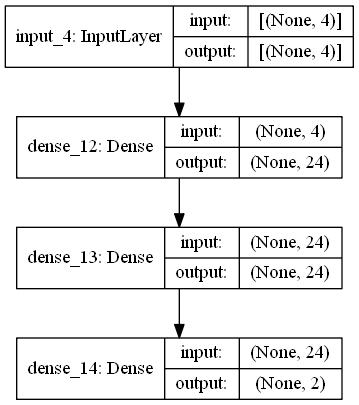

In [11]:
model = build_architecture(0.01)
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [4]:
def select_action(state, policy, epsilon, decay_epsilon, model):
    if policy == 'egreedy':
            if epsilon > np.random.rand(1)[0]:
                action = random.randrange(game.action_space.n)
            else:
                # Predict action Q-values from environment state
                action_probs = model.predict(state)
                # Take best action
                action = np.argmax(action_probs)
    return action

In [5]:
def experience_replay_update(batch_size, len_history, state_history, state_next_history, rewards_history, action_history, done_history,model):
    # Get indices of samples for replay buffers
    indices = np.random.choice(range(len_history), size = batch_size)

    # Using list comprehension to sample from replay buffer
    state_sample = np.array([state_history[i] for i in indices])
    state_next_sample = np.array([state_next_history[i] for i in indices])
    rewards_sample = np.array([rewards_history[i] for i in indices])
    action_sample = [action_history[i] for i in indices]
    done_sample = tf.convert_to_tensor([float(done_history[i]) for i in indices])

    # Build the updated Q-values for the sampled future states
    # Q value = reward + discount factor * expected future reward
            
    for i in range(batch_size):
        y_train = model.predict(state_sample[i])
        if not done_sample[i]:
            y_train[0][action_sample[i]] = rewards_sample[i] + gamma*np.max(model.predict(state_next_sample[i]))
        else:
            y_train[0][action_sample[i]] = rewards_sample[i]
        #Train the model
        model.fit(state_sample[i], y_train, verbose = 0)
    

In [10]:
def cartpole(n_runs, learning_rate, gamma, policy, epsilon, experience_replay, batch_size, decay_epsilon):
    
    model = build_architecture(learning_rate)
    
    ###Experience replay buffers###
    action_history = []
    state_history = []
    state_next_history = []
    rewards_history = []
    done_history = []
    episode_reward_history = []
    running_reward = 0
    # Maximum replay length
    max_memory_length = 1000000
    # Train the model after a fixed number of actions
    run = 0

    for i in range(n_runs):  # Run until solved
        state = game.reset()
        state = np.reshape(state, [1,state_shape])
        episode_reward = 0
        run += 1
        n_steps = 0
    
        while True:
            #game.render() #Adding this line would show the attempts of the agent in a pop up window.
            n_steps +=1
            #Select an action according to the policy
            action = select_action(state, policy, epsilon, decay_epsilon, model)
            
            # Apply the sampled action in our environment
            state_next, reward, done, _ = game.step(action)
            state_next = np.reshape(state_next, [1,state_shape])

            episode_reward += reward

            # Save actions and states in replay buffer
            action_history.append(action)
            state_history.append(state)
            state_next_history.append(state_next)
            done_history.append(done)
            rewards_history.append(reward)
            state = state_next

            # Update every fixed number of frames and once batch size is reached
            if len(done_history) > batch_size and not done and experience_replay:
                len_history = len(done_history)
                experience_replay_update(batch_size, len_history, state_history, state_next_history, 
                                         rewards_history, action_history, done_history,model)

            # Limit the state and reward history
            if len(rewards_history) > max_memory_length:
                del rewards_history[:1]
                del state_history[:1]
                del state_next_history[:1]
                del action_history[:1]
                del done_history[:1]
            
            # If done print the score of current run
            if done:
                print("Run:" + str(run) + ", Steps:" + str(n_steps) + ", Epsilon:" + str(epsilon))
                break
                
        # Decay probability of taking random action
        if decay_epsilon:
            epsilon *= decay_rate
            epsilon = max(epsilon, epsilon_min)

        # Update running reward to check condition for solving
        episode_reward_history.append(episode_reward)

    return episode_reward_history

In [15]:
cartpole(n_runs=2000, learning_rate=0.01, gamma=0.995, policy = 'egreedy', epsilon=1, experience_replay=True, batch_size=20, decay_epsilon=True)

Run:1, Steps:16, Epsilon:1
Run:2, Steps:14, Epsilon:0.95
Run:3, Steps:13, Epsilon:0.9025
Run:4, Steps:30, Epsilon:0.8573749999999999
Run:5, Steps:9, Epsilon:0.8145062499999999
Run:6, Steps:26, Epsilon:0.7737809374999999
Run:7, Steps:21, Epsilon:0.7350918906249998
Run:8, Steps:13, Epsilon:0.6983372960937497
Run:9, Steps:13, Epsilon:0.6634204312890623
Run:10, Steps:12, Epsilon:0.6302494097246091
Run:11, Steps:16, Epsilon:0.5987369392383786
Run:12, Steps:21, Epsilon:0.5688000922764596
Run:13, Steps:13, Epsilon:0.5403600876626365
Run:14, Steps:11, Epsilon:0.5133420832795047
Run:15, Steps:9, Epsilon:0.48767497911552943
Run:16, Steps:42, Epsilon:0.46329123015975293
Run:17, Steps:12, Epsilon:0.44012666865176525
Run:18, Steps:12, Epsilon:0.41812033521917696
Run:19, Steps:10, Epsilon:0.3972143184582181
Run:20, Steps:11, Epsilon:0.37735360253530714
Run:21, Steps:11, Epsilon:0.35848592240854177
Run:22, Steps:17, Epsilon:0.34056162628811465
Run:23, Steps:11, Epsilon:0.3235335449737089
Run:24, Step

KeyboardInterrupt: 